In [96]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import trange
from geopy import distance
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics.pairwise import euclidean_distances

### Load auxiliary data

In [97]:
coe_prices = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-coe-prices.csv")
existing_mrt = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-mrt-existing-stations.csv")
future_mrt = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-mrt-planned-stations.csv")
schools = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-primary-schools.csv")
malls = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-shopping-malls.csv")
stock = pd.read_csv("data/auxiliary-data/auxiliary-data/sg-stock-prices.csv")

### Load Preprocessed Data

In [98]:
dataset = pd.read_csv("data/train_preprocessed.csv")
dataset.head()

,rent_approval_date,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,planning_area,region,monthly_rent,rent_approval_year,rent_approval_month,flat_type_2-room,flat_type_3-room,flat_type_4-room,flat_type_5-room,flat_type_executive,flat_model_cat
0,2021-09,new generation,67.0,1983,1.344518,103.738630,jurong east,west region,1600,2021,9,0,1,0,0,0,0
1,2022-05,new generation,92.0,1978,1.330186,103.938717,bedok,east region,2250,2022,5,0,0,1,0,0,0
2,2022-10,improved,67.0,1971,1.332242,103.845643,toa payoh,central region,1900,2022,10,0,1,0,0,0,1
3,2021-08,apartment,149.0,1993,1.370239,103.962894,pasir ris,east region,2850,2021,8,0,0,0,0,1,2
4,2022-11,improved,68.0,1972,1.320502,103.863341,kallang,central region,2100,2022,11,0,1,0,0,0,1


### Calculate the mean over the medians of each flat type's rental price

In [99]:
rm2 = dataset.loc[dataset["flat_type_2-room"]==1]
rm3 = dataset.loc[dataset["flat_type_3-room"]==1]
rm4 = dataset.loc[dataset["flat_type_3-room"]==1]
rm5 = dataset.loc[dataset["flat_type_3-room"]==1]
ea = dataset.loc[dataset["flat_type_executive"]==1]

In [112]:
rms = {"2-room": rm2, "3-room": rm3, "4-room": rm4, "5-room": rm5, "executive": ea}
median_rental = {}
for rm in rms.keys():
    ft = rms[rm]
    median_rental[rm] = []
    for y in [2021, 2022, 2023]:
        yearly_data = ft.loc[ft['rent_approval_year']==y]
        for m in range(1, 13):
            if m in yearly_data['rent_approval_month'].unique():
                monthly_data = yearly_data.loc[yearly_data['rent_approval_month']==m]
                median_rent = monthly_data['monthly_rent'].median()
                median_rental[rm].append(median_rent)

median2 = median_rental["2-room"]
median3 = median_rental["3-room"]
median4 = median_rental["4-room"]
median5 = median_rental["5-room"]
mediane = median_rental["executive"]

mean_prices = [(median2[i] + median3[i] + median4[i] + median5[i] + mediane[i])/5 for i in range(len(median2))]
mean_rental_change = [(mean_prices[i]-mean_prices[i-1])/(mean_prices[i-1]) for i in range(1, len(mean_prices))]
mean_rental_change.insert(0, 0.0)
print(mean_rental_change)
print(mean_prices)

# adfuller stationarity test
result = adfuller(mean_rental_change)
print(result)

[0.0, -0.015463917525773196, 0.015706806282722512, -0.020618556701030927, 0.005263157894736842, 0.041884816753926704, 0.005025125628140704, 0.01, -0.01485148514851485, 0.020100502512562814, 0.009852216748768473, 0.00975609756097561, 0.016908212560386472, -0.0023752969121140144, 0.02857142857142857, -0.013888888888888888, 0.06338028169014084, 0.006622516556291391, 0.0043859649122807015, 0.048034934497816595, 0.03333333333333333, -0.008064516129032258, 0.08943089430894309, -0.011194029850746268, 0.016981132075471698, 0.05009276437847866, 0.007067137809187279, 0.017543859649122806, -0.03793103448275862, 0.08243727598566308, -0.009933774834437087]
[1940.0, 1910.0, 1940.0, 1900.0, 1910.0, 1990.0, 2000.0, 2020.0, 1990.0, 2030.0, 2050.0, 2070.0, 2105.0, 2100.0, 2160.0, 2130.0, 2265.0, 2280.0, 2290.0, 2400.0, 2480.0, 2460.0, 2680.0, 2650.0, 2695.0, 2830.0, 2850.0, 2900.0, 2790.0, 3020.0, 2990.0]
(-8.658082393297557, 4.906593873596558e-14, 0, 30, {'1%': -3.6699197407407405, '5%': -2.96407074074

### Plot Stock Price Change

(-7.81393621462268, 6.95064942221435e-12, 1, 30, {'1%': -3.6699197407407405, '5%': -2.9640707407407407, '10%': -2.621171111111111}, -61.07304812700082)


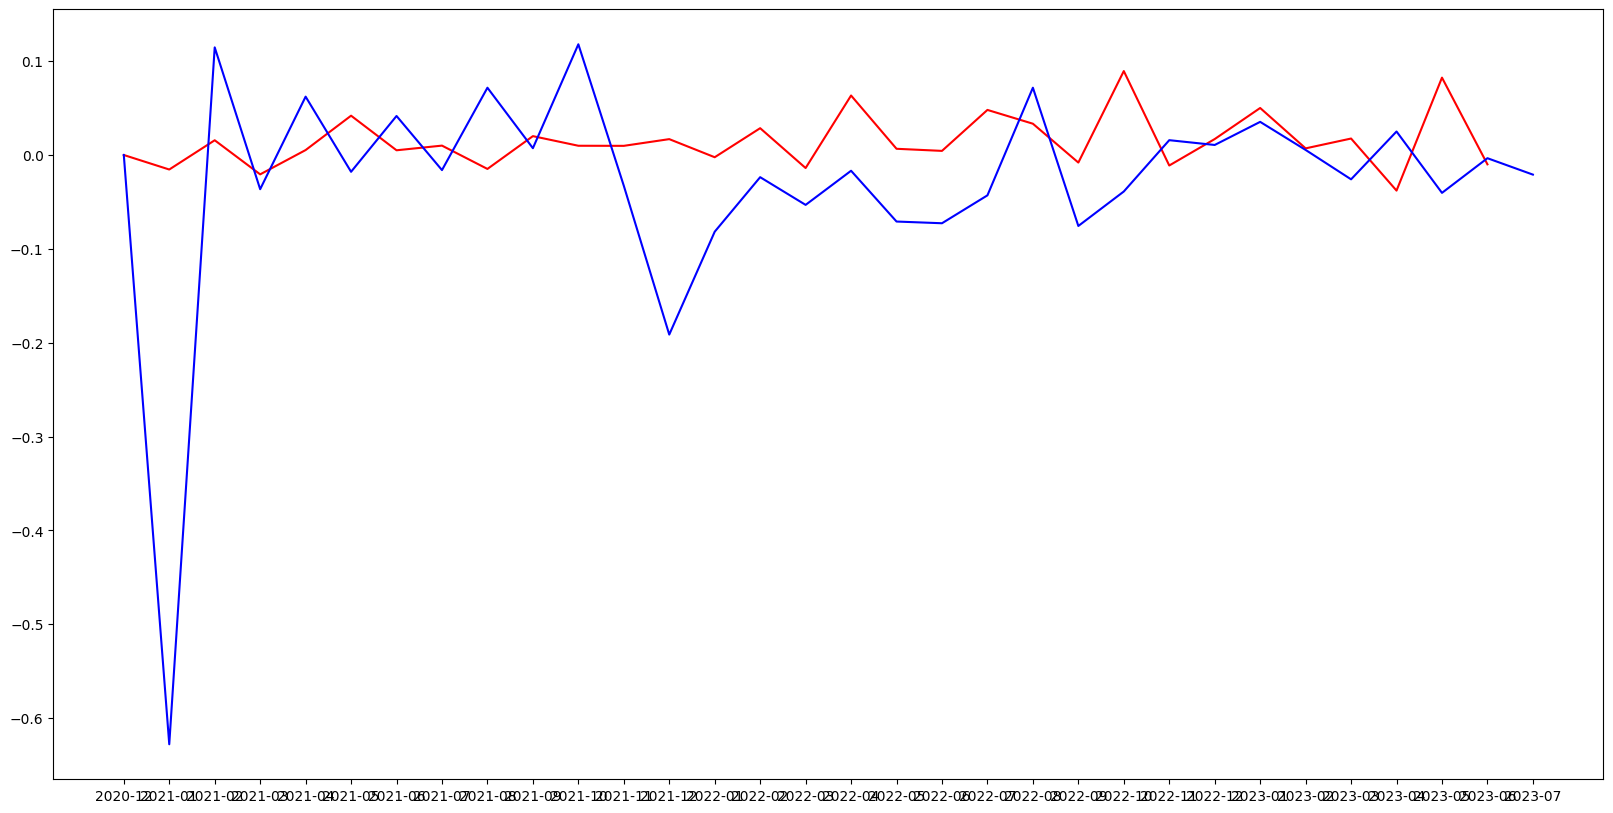

In [113]:
stock_prices = pd.DataFrame(columns=['date', 'name', 'mean_price'])

# # find the average monthly closing price
mean_stock_prices = stock.groupby(pd.PeriodIndex(stock['date'], freq="M"))['close'].mean()

# find the monthly percentage change
mean_stock_change = mean_stock_prices.pct_change()
mean_stock_change[0] = 0
mean_stock_change.index = mean_stock_prices.index.strftime('%Y-%m')

# adfuller stationarity test
result = adfuller(mean_stock_change)
print(result)

plt.figure(figsize=(20, 10))
plt.plot(mean_rental_change, color="red")
plt.plot(mean_stock_change, color="blue")

### Inspect COE Price Trend

In [114]:
coe_prices.head()

,year,category,month,bidding,price,quota,bids
0,2023,a,july,2,95202,581,728
1,2023,a,july,1,97000,588,756
2,2023,a,june,2,96206,586,751
3,2023,a,june,1,98001,581,881
4,2023,a,may,2,92000,596,936


In [115]:
months = {
    "january": 1,
    "february": 2,
    "march": 3,
    "april": 4,
    "may": 5,
    "june": 6,
    "july": 7,
    "august": 8,
    "september": 9,
    "october": 10,
    "november": 11,
    "december": 12
}

coe_prices['month'] = coe_prices['month'].apply(lambda x: months[x])
coe_prices["date"] = pd.to_datetime(coe_prices[["year", "month"]].assign(DAY=1))
coe_prices["date"] = np.where(coe_prices["bidding"]==2, coe_prices['date']+pd.DateOffset(days=15), coe_prices['date'])
coe_prices["date"] = coe_prices["date"].dt.strftime('%Y-%m-%d')
coe_prices.dtypes


year         int64
category    object
month        int64
bidding      int64
price        int64
quota        int64
bids         int64
date        object
dtype: object

(-5.736550710858699, 6.418528934119588e-07, 1, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, -67.02475444197385)


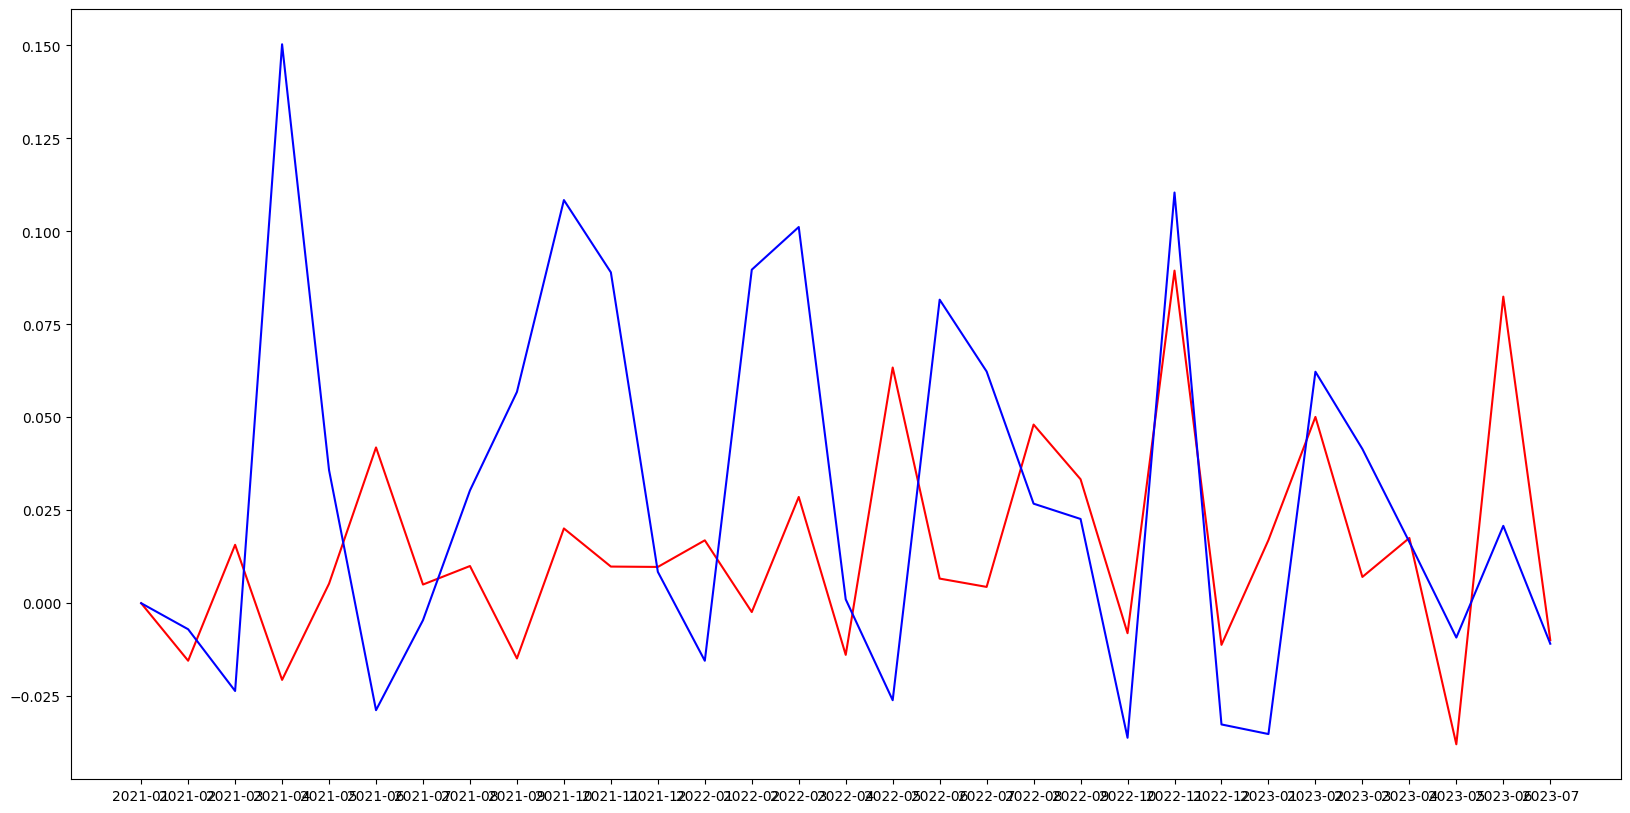

In [126]:
coe_prices.sort_values(by='date', ascending=True)
coe_prices_a = coe_prices.loc[coe_prices['category']=='a']
coe_prices_b = coe_prices.loc[coe_prices['category']=='b']
coe_prices_c = coe_prices.loc[coe_prices['category']=='c']
coe_prices_e = coe_prices.loc[coe_prices['category']=='e']
coe_prices['category'].unique()
coe_price_trend = coe_prices.groupby(pd.PeriodIndex(coe_prices['date'], freq="M"))['price'].mean()

# percentage monthly change
mean_coe_change = coe_price_trend.pct_change()
mean_coe_change[0] = 0
mean_coe_change.index = mean_coe_change.index.strftime('%Y-%m')

# adfuller stationarity test
result= adfuller(mean_coe_change)
print(result)

plt.figure(figsize=(20, 10))
plt.plot(mean_rental_change, color='red')
plt.plot(mean_coe_change, color='blue')

Results of ADFuller Test <br>
t-test result = -1.009 <br>
p-value = 0.75 <br>
t-test result is greater than all critical values <br>
since p-value = 0.75 > 0.05, null hypothesis cannot be rejected and series is not stationary <br>

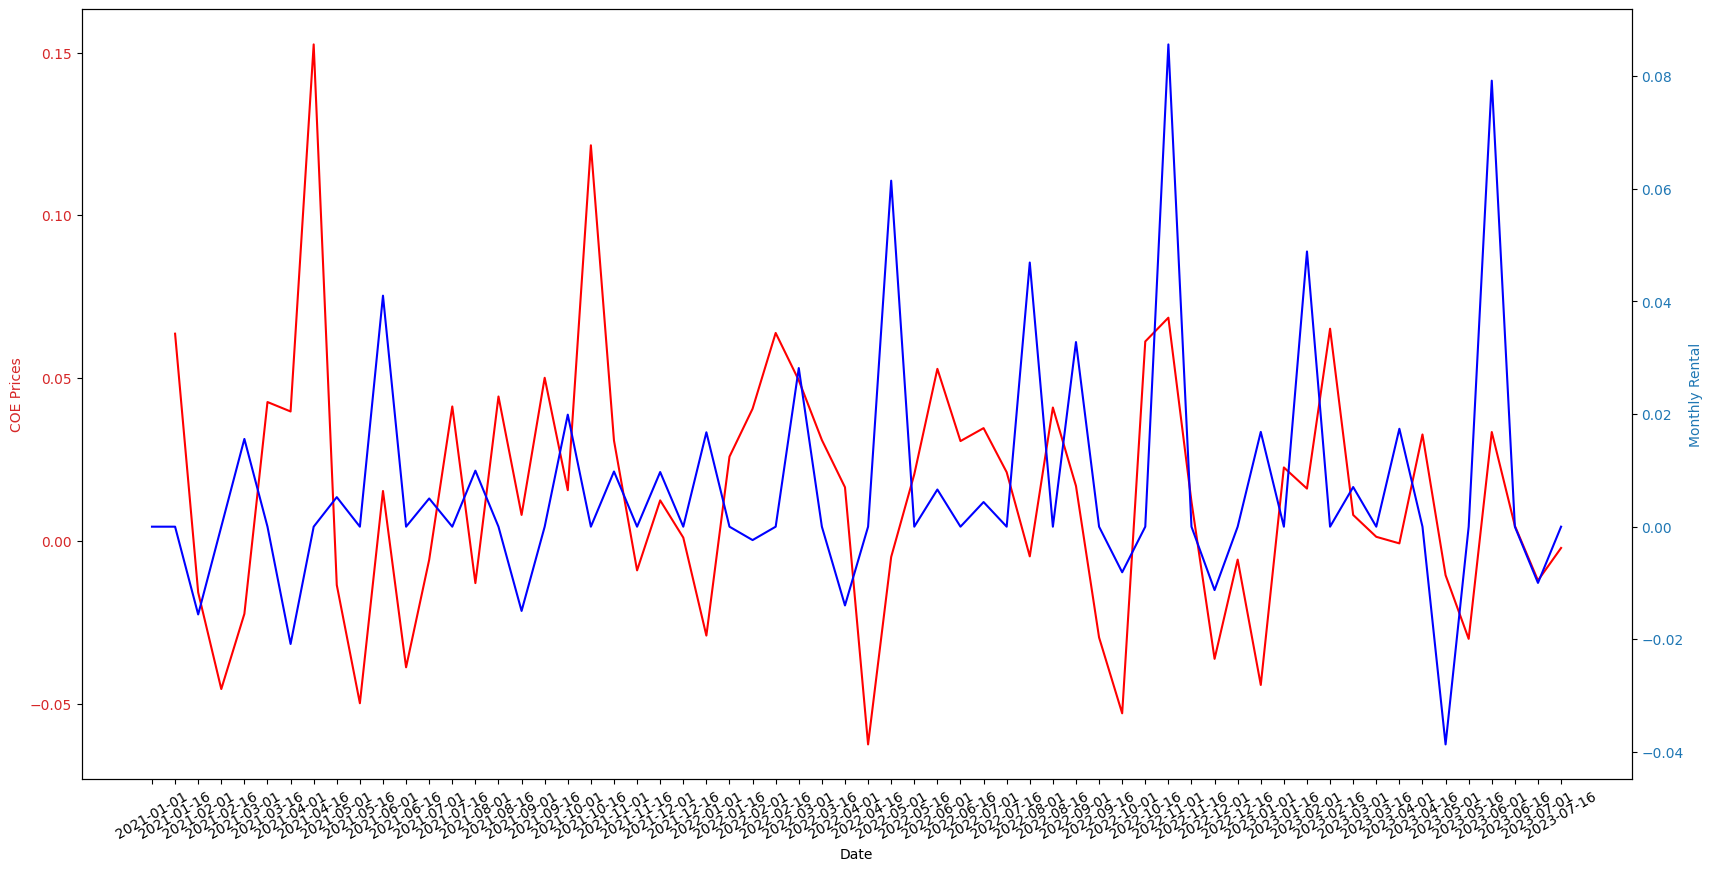

In [82]:
fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)


color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('COE Prices', color=color)
# ax1.plot(coe_price_trend, color='red')
ax1.plot(coe_price_trend_stationary, color='red')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=30)
# ax1.axis([min(coe_prices_a["date"]), max(coe_prices_a["date"]), min(coe_prices["price"]), max(coe_prices["price"])+10000])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Monthly Rental', color=color)  # we already handled the x-label with ax1
# for k in median_prices.keys():
ax2.plot(coe_prices_a.sort_values(by='date', ascending=True)['date'], mean_prices_stationary, color='blue')
# ax2.axis([min(coe_prices_a["date"]), max(coe_prices_a["date"]), 0, 7000])
# ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

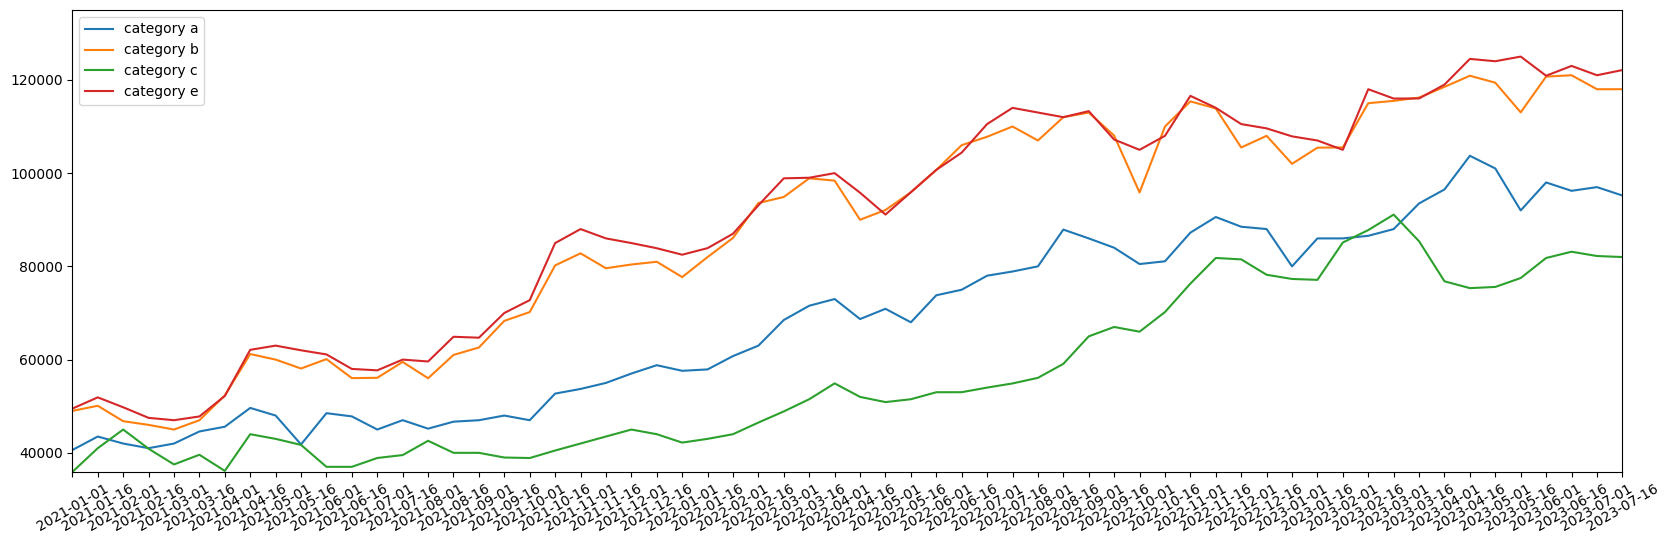

In [12]:
plt.figure(figsize=(20, 6))
plt.plot(coe_prices_a["date"], coe_prices_a["price"])
plt.plot(coe_prices_b["date"], coe_prices_b["price"])
plt.plot(coe_prices_c["date"], coe_prices_c["price"])
plt.plot(coe_prices_e["date"], coe_prices_e["price"])
plt.xticks(coe_prices_a["date"], rotation=30)
plt.axis([min(coe_prices_a["date"]), max(coe_prices_a["date"]), min(coe_prices["price"]), max(coe_prices["price"])+10000])
plt.legend(['category a', 'category b', 'category c', 'category e'])

### Plot Price to Location for Each House

<Axes: xlabel='longitude', ylabel='latitude'>

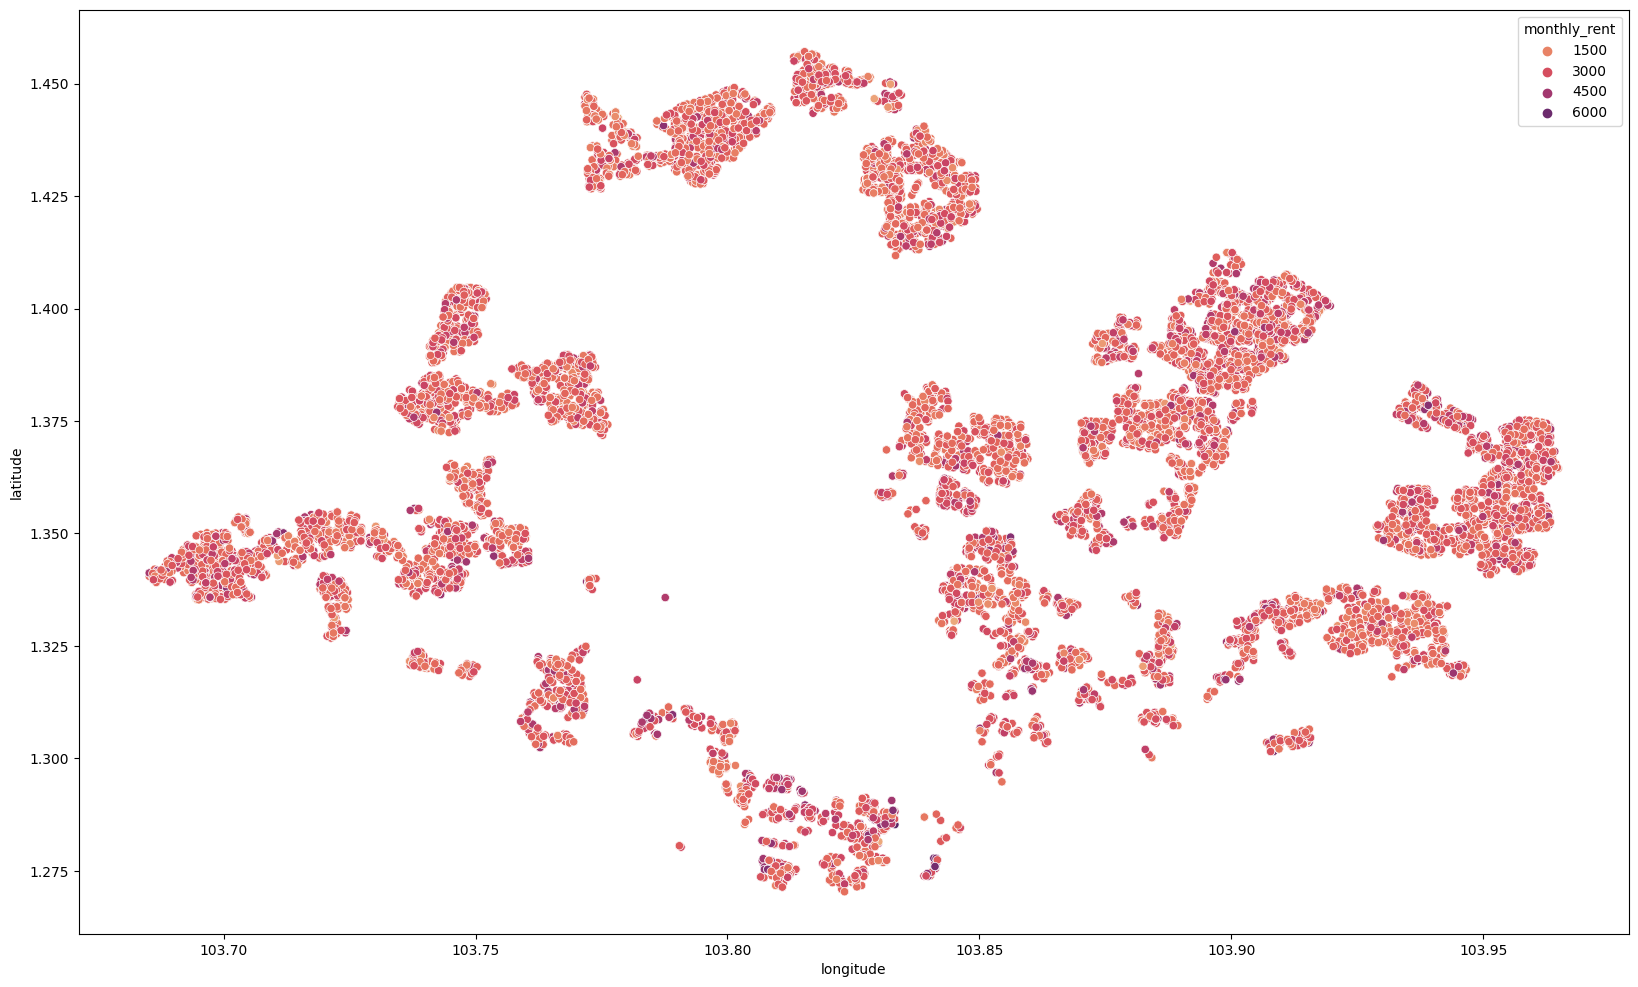

In [13]:
plt.figure(figsize=(20, 12))
sns.scatterplot(dataset, x="longitude", y="latitude", hue="monthly_rent", palette="flare")

### Plot Locations of Places of Interest

In [14]:
existing_mrt


,code,name,opening_year,latitude,longitude
0,NS1,Jurong East,1990,1.333295,103.742154
1,NS2,Bukit Batok,1990,1.349035,103.749526
2,NS3,Bukit Gombak,1990,1.358663,103.751913
3,NS4,Choa Chu Kang,1990,1.385363,103.744371
4,NS5,Yew Tee,1996,1.397476,103.747418
...,...,...,...,...,...
157,TE17,Outram Park,2022,1.280242,103.840052
158,TE18,Maxwell,2022,1.280533,103.843884
159,TE19,Shenton Way,2022,1.277717,103.850368
160,TE20,Marina Bay,2022,1.276311,103.854605


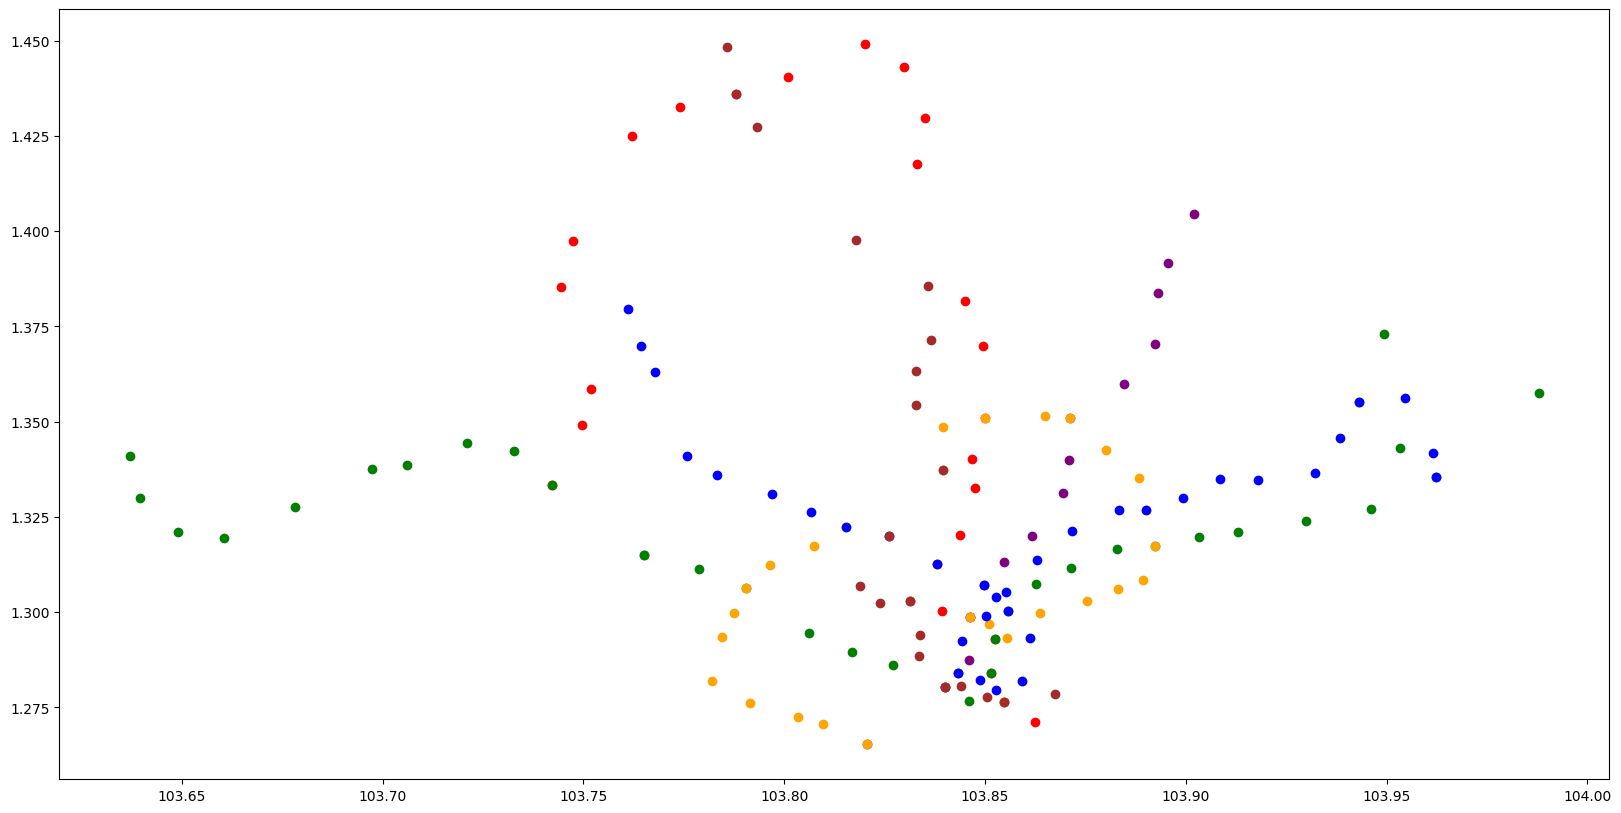

In [15]:
plt.figure(figsize=(20,10))
mrt_colours = {"NS": "red", "EW": "green", "CG": "green", "NE": "purple", "CC": "orange", "DT": "blue", "TE": "brown", "CE": "orange"}
for i in range(len(existing_mrt)):
    code = existing_mrt.loc[i, "code"][:2]
    color = mrt_colours[code]
    plt.scatter(x=existing_mrt.loc[i, "longitude"], y=existing_mrt.loc[i, "latitude"], c=color)
    

In [16]:
future_mrt.head()


,code,name,opening_year,latitude,longitude
0,NaN,Brickland,2030,1.369700,103.747900
1,NaN,Sungei Kadut,2030,1.413300,103.748800
2,NaN,Punggol Coast,2024,1.415280,103.911110
3,NaN,Bukit Brown,TBA,1.333639,103.830075
4,NaN,Keppel,2026,1.270100,103.831000


In [17]:
malls.head()

,name,latitude,longitude
0,100 AM,1.274588,103.843471
1,313@Somerset,1.301385,103.837684
2,Aperia,1.310867,103.863930
3,Balestier Hill Shopping Centre,1.325596,103.842572
4,Bugis Cube,1.298141,103.855635


In [137]:
schools.head()

,name,latitude,longitude
0,Admiralty Primary School,1.454038,103.817436
1,Ahmad Ibrahim Primary School,1.433153,103.832942
2,Ai Tong School,1.360583,103.833020
3,Alexandra Primary School,1.291334,103.824425
4,Anchor Green Primary School,1.390370,103.887165


### Print monthly rent price distribution

Average monthly rent value: 2590.3283333333334
Median monthly rent value: 2400.0


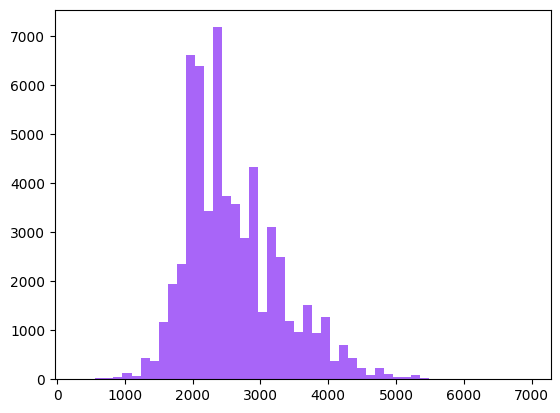

In [7]:
print("Average monthly rent value: {}".format(dataset['monthly_rent'].mean()))
print("Median monthly rent value: {}".format(dataset['monthly_rent'].median()))
plt.hist(dataset['monthly_rent'], color='#a865f8', bins=50)
plt.show()

### Print skewness value in each column

In [8]:
dataset.skew()

/home/thong/library/cs5228_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


floor_area_sqm         0.238213
lease_commence_date    0.298661
latitude               0.242286
longitude             -0.230824
monthly_rent           0.864935
rent_approval_year     0.338865
rent_approval_month    0.289192
flat_type_2-room       7.857716
flat_type_3-room       0.796798
flat_type_4-room       0.561665
flat_type_5-room       1.179668
flat_type_executive    3.750997
flat_model_cat         0.687331
dtype: float64

### Relation between the distance of the flat from the MRT/School/Mall and its rental price

### a) MRT

In [92]:
flat_latitude_list = list(dataset['latitude'])
flat_longtitude_list = list(dataset['longitude'])
flat_coordinates = [flat_latitude_list, flat_longtitude_list]
monthly_rent_list = list(dataset['monthly_rent'])

mrt_latitude_list = list(existing_mrt['latitude'])
mrt_longitude_list = list(existing_mrt['longitude'])
mrt_coordinates = [mrt_latitude_list, mrt_longitude_list]

In [96]:
flat_mrt_distances = []

for i in trange(len(flat_coordinates[0])):
    distance_list = []
    flat = (flat_coordinates[0][i], flat_coordinates[1][i])
    for j in range(len(mrt_coordinates[0])):
        mrt = (mrt_coordinates[0][j], mrt_coordinates[1][j])
        dist = distance.distance(flat, mrt).km
        distance_list.append(dist)
    flat_mrt_distances.append(distance_list)
    
flat_mrt_distance_tensor = torch.tensor(flat_mrt_distances)
flat_mrt_min_dist_tensor, _ = flat_mrt_distance_tensor.min(dim=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [28:46<00:00, 34.76it/s]


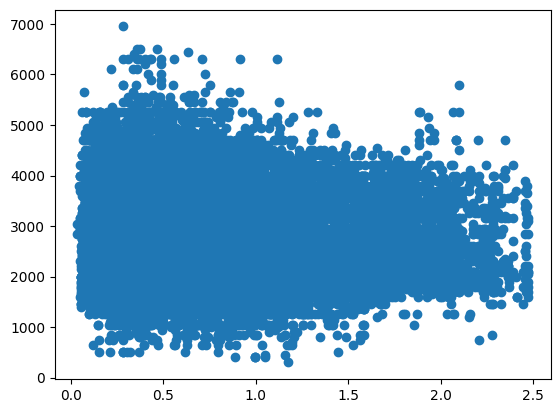

In [104]:
plt.scatter(flat_mrt_min_dist_tensor.tolist(), monthly_rent_list)
plt.show()

### b) School

In [106]:
flat_latitude_list = list(dataset['latitude'])
flat_longtitude_list = list(dataset['longitude'])
flat_coordinates = [flat_latitude_list, flat_longtitude_list]
monthly_rent_list = list(dataset['monthly_rent'])

school_latitude_list = list(schools['latitude'])
school_longitude_list = list(schools['longitude'])
school_coordinates = [school_latitude_list, school_longitude_list]

In [107]:
flat_school_distances = []

for i in trange(len(flat_coordinates[0])):
    distance_list = []
    flat = (flat_coordinates[0][i], flat_coordinates[1][i])
    for j in range(len(school_coordinates[0])):
        school = (school_coordinates[0][j], school_coordinates[1][j])
        dist = distance.distance(flat, school).km
        distance_list.append(dist)
    flat_school_distances.append(distance_list)
    
flat_school_distance_tensor = torch.tensor(flat_school_distances)
flat_school_min_dist_tensor, _ = flat_school_distance_tensor.min(dim=1)

100%|███████████| 60000/60000 [32:32<00:00, 30.74it/s]


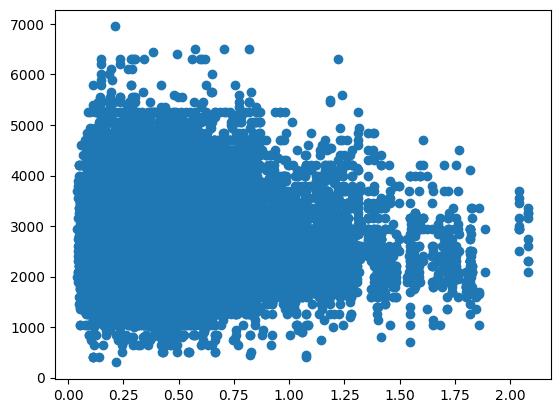

In [110]:
plt.scatter(flat_school_min_dist_tensor.tolist(), monthly_rent_list)
plt.show()

### c) Mall

In [112]:
flat_latitude_list = list(dataset['latitude'])
flat_longtitude_list = list(dataset['longitude'])
flat_coordinates = [flat_latitude_list, flat_longtitude_list]
monthly_rent_list = list(dataset['monthly_rent'])

mall_latitude_list = list(malls['latitude'])
mall_longitude_list = list(malls['longitude'])
mall_coordinates = [mall_latitude_list, mall_longitude_list]

In [115]:
flat_mall_distances = []

for i in trange(len(flat_coordinates[0])):
    distance_list = []
    flat = (flat_coordinates[0][i], flat_coordinates[1][i])
    for j in range(len(mall_coordinates[0])):
        mall = (mall_coordinates[0][j], mall_coordinates[1][j])
        dist = distance.distance(flat, mall).km
        distance_list.append(dist)
    flat_mall_distances.append(distance_list)
    
flat_mall_distance_tensor = torch.tensor(flat_mall_distances)
flat_mall_min_dist_tensor, _ = flat_mall_distance_tensor.min(dim=1)

100%|███████████| 60000/60000 [28:47<00:00, 34.72it/s]


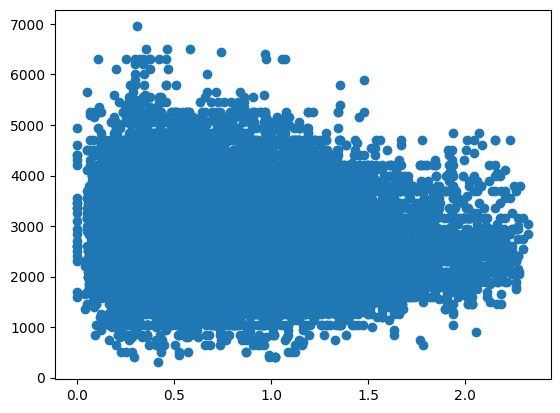

In [116]:
plt.scatter(flat_mall_min_dist_tensor.tolist(), monthly_rent_list)
plt.show()